In [1]:
import matplotlib
from matplotlib import pylab
import pandas as pd
from import_data import import_legacy

#1
# Import data from older seasons

#Specify columns for team_avgs calculation from following list:
    # ~~ Must always include Season, TeamID, Wins, Losses ~~
    # PPG, PAPG, RPG, APG, SPG, BPG, PFPG, TOPG, SOS, FGP
cols = ['Season', 'TeamID', 'Wins', 'Losses', 'PPG', 'PAPG', 'RPG', 'APG', 'SPG', 'BPG', 'PFPG', 'TOPG', 'SOS', 'FGP']

# Specify seasons to import data from, from 2006 to 2019 (inclusive)
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# import 2006-2019 regular season and tournament data, calculate team averages for tournament teams in each year
runtime, team_avgs, reg_season_df, tourney_df, seeds_df = import_legacy(cols, years)

# Estimated runtime: ~20 s
print(f"Runtime: {runtime:.2f} s\n")
print("Team Averages: \n", team_avgs)
print("All regular season matchups: \n", reg_season_df)


C:\Users\akraw\repos\NCAATourneyPredictor\NCAATourneyPredictor\import_data.py:71: DtypeWarning: Columns (0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv("./MRegularSeasonDetailedResults.csv",


Runtime: 19.60 s

Team Averages: 
      Season  TeamID  Wins  Losses        PPG       PAPG        RPG        APG  \
0    2006.0  1104.0  17.0    12.0  69.965517  67.137931  37.000000  12.206897   
1    2006.0  1266.0  19.0    10.0  74.206897  69.655172  35.551724  15.275862   
2    2006.0  1130.0  25.0     7.0  74.531250  66.875000  35.187500  17.812500   
3    2006.0  1334.0  22.0     7.0  73.724138  63.586207  35.172414  15.655172   
4    2006.0  1181.0  30.0     3.0  82.515152  68.969697  32.909091  15.363636   
..      ...     ...   ...     ...        ...        ...        ...        ...   
891  2019.0  1205.0  20.0    11.0  75.774194  73.419355  32.870968  13.612903   
892  2019.0  1439.0  24.0     8.0  74.000000  62.093750  32.593750  15.343750   
893  2019.0  1387.0  23.0    12.0  67.057143  63.742857  39.771429  12.971429   
894  2019.0  1449.0  26.0     8.0  69.823529  64.382353  31.588235  11.676471   
895  2019.0  1429.0  27.0     6.0  79.030303  67.090909  40.060606  17.090

In [2]:
from import_data import import_year

#2
# Import data from 2022 season

tourney_team_ids = [1211, 1112, 1242, 1124, 1120, 1246, 1437, 1181, 1458, 1397, 1345, 1403, 1417, 1228, 1344, 1116,
                        1163, 1222, 1388, 1234, 1104, 1261, 1400, 1161, 1425, 1293, 1277, 1326, 1129, 1314, 1361, 1371,
                        1166, 1395, 1266, 1272, 1362, 1274, 1260, 1172, 1235, 1276, 1461, 1353, 1231, 1439, 1323, 1412,
                        1350, 1308, 1151, 1355, 1436, 1103, 1255, 1463, 1159, 1286, 1174, 1389, 1240, 1168, 1209, 1313,
                        1460, 1136, 1411, 1394]

#Specify columns for team_avgs calculation from following list:
    # ~~ Must always include Season, TeamID, Wins, Losses ~~
    # PPG, PAPG, RPG, APG, SPG, BPG, PFPG, TOPG, SOS, FGP
cols = ['Season', 'TeamID', 'Wins', 'Losses', 'PPG', 'PAPG', 'RPG', 'APG', 'SPG', 'BPG', 'PFPG', 'TOPG', 'SOS', 'FGP']

runtime, team_avgs_2022, reg_2022_df = import_year(cols)

# Estimated runtime: 1 s
print(f"Runtime: {runtime:.2f} s\n")
print("Team Averages: \n", team_avgs_2022)
print("All regular season matchups: \n", reg_2022_df)


Runtime: 0.56 s

Team Averages: 
     Season  TeamID  Wins  Losses        PPG       PAPG        RPG        APG  \
0   2022.0  1211.0  26.0     3.0  87.827586  65.344828  41.482759  18.206897   
1   2022.0  1112.0  31.0     3.0  84.558824  67.529412  41.352941  19.911765   
2   2022.0  1242.0  28.0     6.0  78.588235  68.147059  37.352941  15.441176   
3   2022.0  1124.0  26.0     6.0  76.500000  63.625000  37.125000  15.843750   
4   2022.0  1120.0  27.0     5.0  78.718750  67.031250  39.937500  14.593750   
..     ...     ...   ...     ...        ...        ...        ...        ...   
63  2022.0  1313.0  24.0     6.0  75.100000  63.733333  38.766667  12.633333   
64  2022.0  1460.0  21.0    13.0  75.470588  71.058824  34.882353  13.941176   
65  2022.0  1136.0  22.0     9.0  77.903226  72.741935  41.548387  14.096774   
66  2022.0  1411.0  18.0    12.0  69.233333  65.500000  39.533333  10.833333   
67  2022.0  1394.0  23.0    11.0  76.911765  69.941176  38.352941  15.029412   

     

In [17]:
import time
from training import randomize_winner
#3
# Randomize order of winner in historical seasons
# Can't apply this to 2022 season due to differences in data

start_time = time.time()

train_cols = ["Season", "Team1ID", "Team2ID", "Winner", "Team1W", "Team1L", "Team1PPG", "Team1PAPG", "Team1RPG", "Team1APG",
              "Team1SPG", "Team1BPG", "Team1PFPG", "Team1TOPG", "Team1SOS", "Team1FGP", "Team2W", "Team2L", "Team2PPG",
              "Team2PAPG", "Team2RPG", "Team2APG", "Team2SPG", "Team2BPG", "Team2PFPG", "Team2TOPG", "Team2SOS", "Team2FGP"]

trim_tourney_df = tourney_df[["Season", "WTeamID", "LTeamID"]]

# For historical data, randomize the order of winning and losing teams
train_DF = randomize_winner(trim_tourney_df, team_avgs, train_cols, seeds_df, cols, years)

# Limit data to more recent games (since 2010)
train_data = train_DF[train_DF['Season'] >= 2010]
train_labels = train_data['Winner'].astype("int")
train_data = train_data.drop(columns=['Winner'])

print(f"Runtime: {time.time() - start_time:.2f} s\n")
print(train_data)
print(train_labels)


Runtime: 6.81 s

     Season Team1ID Team2ID Team1W Team1L   Team1PPG  Team1PAPG   Team1RPG  \
252  2010.0  1124.0  1358.0   24.0    7.0  76.709677  66.548387  38.645161   
253  2010.0  1139.0  1431.0   28.0    4.0   70.09375   60.03125   32.84375   
254  2010.0  1140.0  1196.0   28.0    5.0  82.606061  65.666667  36.969697   
255  2010.0  1242.0  1250.0   32.0    2.0  81.764706  63.794118  40.529412   
256  2010.0  1243.0  1317.0   25.0    7.0   79.46875   69.21875      39.25   
..      ...     ...     ...    ...    ...        ...        ...        ...   
877  2019.0  1246.0  1120.0   27.0    6.0  76.727273  65.424242  38.424242   
878  2019.0  1181.0  1277.0   29.0    5.0       83.5  67.558824  41.764706   
879  2019.0  1277.0  1403.0   28.0    6.0  78.823529  65.529412  40.911765   
880  2019.0  1438.0  1120.0   29.0    3.0   71.84375    55.0625     34.625   
881  2019.0  1438.0  1403.0   29.0    3.0   71.84375    55.0625     34.625   

      Team1APG  Team1SPG  ...   Team2PPG  Team

In [5]:
from training import tourney_2022
import time

#4
# Calculate stat averages for 2022 tourney teams

start_time = time.time()

d = {'Team1ID': [1211,1129,1163,1116,1104,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1246,1112,1371,1222,1228,1161,1397,1326,1437,1242,1361,1234,1344,1261,1458,1425,1120,1211,1116,1403,1181,1124,1417,1345,1293,1112,1228,1397,1437,1242,1344,1458,1120,1211,1181,1417,1345,1112,1437,1242,1274,1181,1314,1437,1242,1181,1242,1242], 'Team2ID': [1209,1272,1308,1436,1323,1286,1172,1168,1313,1266,1231,1103,1439,1463,1362,1389,1460,1395,1412,1151,1276,1255,1260,1174,1411,1166,1350,1355,1235,1159,1274,1240,1272,1308,1323,1277,1314,1388,1400,1389,1395,1222,1276,1326,1166,1350,1235,1274,1116,1403,1314,1389,1222,1276,1344,1235,1116,1389,1222,1274,1314,1437,1314]}
test_cols = ["Season", "Team1ID", "Team2ID", "Team1W", "Team1L", "Team1PPG", "Team1PAPG", "Team1RPG", "Team1APG", "Team1SPG", \
              "Team1BPG", "Team1PFPG", "Team1TOPG", "Team1SOS", "Team1FGP", "Team2W", "Team2L", "Team2PPG", "Team2PAPG", "Team2RPG", "Team2APG", "Team2SPG",\
              "Team2BPG", "Team2PFPG", "Team2TOPG", "Team2SOS", "Team2FGP"]


tourney_2022_df = tourney_2022(d, team_avgs_2022, test_cols)
print(f"Runtime: {time.time() - start_time:.2f} s\n")
print(tourney_2022_df)

Runtime: 0.57 s

    Season Team1ID Team2ID Team1W Team1L   Team1PPG  Team1PAPG   Team1RPG  \
0   2022.0  1211.0  1209.0   26.0    3.0  87.827586  65.344828  41.482759   
1   2022.0  1129.0  1272.0   27.0    7.0  68.705882  60.764706  34.970588   
2   2022.0  1163.0  1308.0   23.0    9.0    75.1875   65.15625     40.875   
3   2022.0  1116.0  1436.0   25.0    8.0  76.939394  68.545455  38.151515   
4   2022.0  1104.0  1323.0   19.0   13.0   79.96875   76.40625   39.96875   
..     ...     ...     ...    ...    ...        ...        ...        ...   
58  2022.0  1437.0  1222.0   26.0    7.0  72.636364  63.090909  34.939394   
59  2022.0  1242.0  1274.0   28.0    6.0  78.588235  68.147059  37.352941   
60  2022.0  1181.0  1314.0   28.0    6.0  80.176471  67.147059  38.294118   
61  2022.0  1242.0  1437.0   28.0    6.0  78.588235  68.147059  37.352941   
62  2022.0  1242.0  1314.0   28.0    6.0  78.588235  68.147059  37.352941   

     Team1APG  Team1SPG  ...   Team2PPG  Team2PAPG   Team2

In [81]:
#5
# TODO
# ~~Austin~~ do we need this cell anymore?
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import numpy as np
from training import randomize_winner

train_DF = randomize_winner(trim_tourney_df, team_avgs, train_cols, seeds_df, cols, years)

In [82]:
import time

#6
# Calculate vegas game-by-game accuracy for 2022 tournament
start_time = time.time()
winners = [1,2,2,1,2,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,2,1,1,1,1,2,2,1,2,1,2,1,1,1,1,1,2,1,1,2,1,2,2,1,1,1,2,2,2,1,2,2,2,1,1,1,1,1,1,1,2,1,1]
vegas_winners = [1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1]

vright = 0
vwrong = 0
for i in range(0,len(vegas_winners)):
    if vegas_winners[i] == winners[i]:
        vright += 1
    else:
        vwrong += 1

#print(f"# of Games correct: ",right)
#print(f"# of Games missed: ",wrong)
#print(f"Accuracy: ", (right) / (right + wrong))

print(f"Runtime: {time.time() - start_time:.4f} s\n")

print(f"Vegas # of Games correct: ",vright)
print(f"Vegas # of Games missed: ",vwrong)
print(f"Vegas Accuracy: ", (vright) / (vright + vwrong))

Runtime: 0.0000 s

Vegas # of Games correct:  42
Vegas # of Games missed:  21
Vegas Accuracy:  0.6666666666666666


In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time

#7
# Finds game-by-game accuracy of some models:
start_time = time.time()
def accuracy(preds):
    right = 0
    wrong = 0
    for i in range(0,len(preds)):
        if preds[i] == winners[i]:
            right += 1
        else:
            wrong += 1
    return right / (right + wrong)

bayes_model = MultinomialNB().fit(train_data, train_labels)
bayes_preds = bayes_model.predict(tourney_2022_df)


tree_model = DecisionTreeClassifier().fit(train_data, train_labels)
tree_preds = tree_model.predict(tourney_2022_df)

forest_model = RandomForestClassifier().fit(train_data, train_labels)
forest_preds = forest_model.predict(tourney_2022_df)

print(f"Runtime: {time.time() - start_time:.2f} s\n")

print(f"Naive Bayes: ", accuracy(bayes_preds))
print(f"Decision Tree: ", accuracy(tree_preds))
print(f"Random Forest: ", accuracy(forest_preds))



Runtime: 0.19 s

Naive Bayes:  0.5555555555555556
Decision Tree:  0.6507936507936508
Random Forest:  0.6825396825396826


In [84]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn import svm

xgb.set_config(verbosity=0)

#7
# Defines a function to predict games using a specified classification model
# NO OUTPUT for this cell, but it should be run to define the functions

def trainAndPredict(classifier, test_df, sampleSize, num_games):

    predicted_games = [0] * num_games

    for i in range(sampleSize):

        train_df_year = train_DF[train_DF['Season'] >= 2010]

        X = train_df_year.drop("Season", axis=1)
        X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
        y = train_df_year["Winner"]
        y = y.astype(int)

        test_X = test_df.drop(["Season", "Team1ID", "Team2ID"], axis=1)

        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(X.values)
        scaled_test = scaler.fit_transform(test_X.values)
        X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)
        test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)

        # This code takes a VERY long time to run (>30 min) so it is commented out

        #C_range = np.logspace(-2, 10, 13)
        #gamma_range = np.logspace(-9, 3, 13)
        #param_grid = dict(gamma=gamma_range, C=C_range)
        #cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
        #grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
        #grid.fit(X, y)

        #print(
        #    "The best parameters are %s with a score of %0.2f"
        #    % (grid.best_params_, grid.best_score_)
        #)

        classifier.fit(X_proc, y)

        preds = classifier.predict(test_proc)
        for i in range(len(preds)):
            if preds[i] == 1:
                predicted_games[i] += 1
        
    overall_pred = [1] * num_games
    for i in range(len(predicted_games)):
        if predicted_games[i] < (sampleSize / 2):
            overall_pred[i] = 2
    return overall_pred

# This shows our prior approach of running 100 randomized trials and reporting the average result
# This was removed because of the long runtime
#for i in range(100):
    #svm_total += trainAndPredict(svm.SVC())

In [85]:
import time

#8
# Predicts game-by-game outcomes from specified years

def predictYear(classifier, year, num_games):
    
    predicted_games = [0] * num_games
    
    test_data = train_DF[train_DF['Season'] == year]
    test_labels = test_data['Winner'].astype("int")
    test_data = test_data.drop(columns=['Winner'])

    training_data = train_DF[train_DF['Season'] != year]
    y = training_data['Winner']

    test_X = test_data.drop(["Season", "Team1ID", "Team2ID"], axis=1)
    X = training_data.drop("Season", axis=1)
    X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
    y = y.astype(int)

    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X.values)
    scaled_test = scaler.fit_transform(test_X.values)
    test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)

    X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)

    accuracy_scores = []
    from sklearn.metrics import accuracy_score

    # Model Fit
    classifier.fit(X_proc, y)

    # Model Prediction
    preds = classifier.predict(test_proc)

    # Accuracy Score
    return accuracy_score(test_labels, preds)

start_time = time.time()

acc_scores = []
for year in years:
    if year > 2010:
        score = predictYear(svm.SVC(C=4.6, gamma=0.01), year, 63)
        acc_scores.append(score)

print(f"Runtime: {time.time() - start_time:.2f} s\n")
print(f"Avg game-by-game accuracy across all games from 2010-2019: {sum(acc_scores) / len(acc_scores):.4f}")

# add XGB example?
        

Runtime: 0.23 s

Avg game-by-game accuracy across all games from 2010-2019: 0.7055


In [86]:
import time

#9
#Game-by-game prediction accuracy:

start_time = time.time()

svm_preds = trainAndPredict(svm.SVC(C=4.2, gamma=0.01), tourney_2022_df, 1, 63)


dt_preds = trainAndPredict(DecisionTreeClassifier(), tourney_2022_df, 25, 63)


rf_preds = trainAndPredict(RandomForestClassifier(), tourney_2022_df, 25, 63)


# ~~~AUSTIN~~~ This gives an error for some reason
#xgb_preds = trainAndPredict(xgb.XGBClassifier(), tourney_2022_df, 1, 63)

print(f"Runtime: {time.time() - start_time:.2f} s\n")

print(f"SVM: {accuracy(svm_preds):.4f}")
print(f"Decision tree: {accuracy(dt_preds):.4f}")
print(f"Random forest: {accuracy(rf_preds):.4f}")
#print(f"XGB: {accuracy(xgb_preds):.4f}")


Runtime: 4.58 s

SVM: 0.6667
Decision tree: 0.5873
Random forest: 0.6508


In [87]:
import time

#10
# Predicts and calculates bracket score for 2022 bracket

#All of the matchups had to be entered by hand due to the nature of the data collection for 2022
#This is something we would change the next time we do the project
firstRound = {'Team1ID': [1211,1129,1163,1116,1104,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1246,1112,1371,1222,1228,1161,1397,1326,1437,1242,1361,1234,1344,1261,1458,1425,1120], 'Team2ID': [1209,1272,1308,1436,1323,1286,1172,1168,1313,1266,1231,1103,1439,1463,1362,1389,1460,1395,1412,1151,1276,1255,1260,1174,1411,1166,1350,1355,1235,1159,1274,1240]}
tournamentRounds = {'Round1': [1211,1272,1308,1116,1323,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1389,1112,1395,1222,1228,1276,1397,1326,1437,1242,1166,1350,1344,1235,1458,1274,1120], \
                    'Round2': [1211,1116,1403,1181,1314,1417,1345,1389,1112,1222,1276,1437,1242,1344,1235,1274], \
                    'Round3': [1116,1181,1314,1389,1222,1437,1242,1274], \
                    'Round4': [1181,1314,1437,1242], 'Round5': [1314, 1242], 'Round6': [1242]}

#Each of the teams are assigned their correct seed, to account for sorting. This was done using an algorithm
#but was included as hard-coded since the seeds never change to reduce runtime
seed_dict = {1211: 'W01', 1209: 'W16', 1129: 'W08', 1272: 'W09', 1163: 'W05', 1308: 'W12', 1116: 'W04', 1436: 'W13', 1104: 'W06', 1323: 'W11', 1403: 'W03', 1286: 'W14', 1277: 'W07', 1172: 'W10', 1181: 'W02', 1168: 'W15', 1124: 'X01', 1313: 'X16', 1314: 'X08', 1266: 'X09', 1388: 'X05', 1231: 'X12', 1417: 'X04', 1103: 'X13', 1400: 'X06', 1439: 'X11', 1345: 'X03', 1463: 'X14', 1293: 'X07', 1362: 'X10', 1246: 'X02', 1389: 'X15', 1112: 'Y01', 1460: 'Y16', 1371: 'Y08', 1395: 'Y09', 1222: 'Y05', 1412: 'Y12', 1228: 'Y04', 1151: 'Y13', 1161: 'Y06', 1276: 'Y11', 1397: 'Y03', 1255: 'Y14', 1326: 'Y07', 1260: 'Y10', 1437: 'Y02', 1174: 'Y15', 1242: 'Z01', 1411: 'Z16', 1361: 'Z08', 1166: 'Z09', 1234: 'Z05', 1350: 'Z12', 1344: 'Z04', 1355: 'Z13', 1261: 'Z06', 1235: 'Z11', 1458: 'Z03', 1159: 'Z14', 1425: 'Z07', 1274: 'Z10', 1120: 'Z02', 1240: 'Z15'}
bracket_df = pd.DataFrame(data=firstRound)

#Predicts tournament outcome and calculates score
def tournament(classifier, round_bracket, round_num, bracket_score):
    round_df = pd.DataFrame(columns=test_cols)
    for row in round_bracket.iterrows():
        temp_list = [2022, row[1]['Team1ID'], row[1]['Team2ID']]
        
        #ordering new teams by seed
        if round_num > 1:
            team1_seed = seed_dict[temp_list[1]]
            team2_seed = seed_dict[temp_list[2]]

            
            team1_prefix = team1_seed[0:1]
            team2_prefix = team2_seed[0:1]

            team1_seed = int(team1_seed[1:3])
            team2_seed = int(team2_seed[1:3])
            
            if team1_seed > team2_seed:
                temp = temp_list[1]
                temp_list[1] = temp_list[2]
                temp_list[2] = temp
                
                
        #print(temp_list)
        team1_row = team_avgs_2022[team_avgs_2022["TeamID"] == temp_list[1]].values.tolist()
        team2_row = team_avgs_2022[team_avgs_2022["TeamID"] == temp_list[2]].values.tolist()
        team1_row[0].pop(0)
        team1_row[0].pop(0)
        team2_row[0].pop(0)
        team2_row[0].pop(0)

        temp_list.extend(team1_row[0])
        temp_list.extend(team2_row[0])
        # add that list to our DF
        temp_series = pd.Series(temp_list, index=test_cols)
        round_df = round_df.append(temp_series, ignore_index=True)
        
    #print(round_df)
    preds = trainAndPredict(classifier, round_df, 1, len(round_df.index))

    #if(round_num == 1):
        #return;
    
    round_dict = {'Team1ID': [], 'Team2ID': []}
    winners_arr = []
    for i in range(0, len(preds)):
        if i % 2 == 0:
            length = len(round_dict['Team1ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team1ID'].append(val)
            winners_arr.append(val)
        else:
            length = len(round_dict['Team2ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team2ID'].append(val)
            winners_arr.append(val)
    for i in range(0, len(winners_arr)):
        #print(f"Predicted: {winners_arr[i]}  Real: {tournamentRounds['Round' + str(round_num)][i]}")
        if winners_arr[i] == tournamentRounds['Round' + str(round_num)][i]:
            bracket_score += 10 * (2**(round_num - 1))
            #print(bracket_score)
    if round_num < 6:
        new_df = pd.DataFrame(data=round_dict)
        tournament(classifier, new_df, round_num+1, bracket_score)
    else:
        print(f"Bracket score (2022): {bracket_score}")

start_time = time.time()

tournament(svm.SVC(C=4.6, gamma=0.01), bracket_df, 1, 0)
print(f"Runtime: {time.time() - start_time:.2f} s\n")


#xgboost    
#eta-[0.05, 0.06, 0.11, 0.13, .15]

Bracket score (2022): 800
Runtime: 0.96 s



Runtime: 0.059 s

Average of 1000 coin flip brackets: 311.15
Editorial remark: This average is suspiciously close to 100*pi, but it seems to converge to ~315 instead


{'whiskers': [<matplotlib.lines.Line2D at 0x2e1634041f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2e163404790>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e1633f8ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e163404d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e163411040>],
 'means': []}

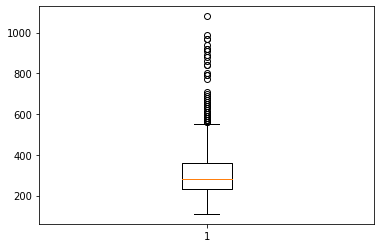

In [89]:
from random import randint
import time

#11
# Demonstration of distribution of coin-flip brackets

actual_winners = ( #Teams are given an index starting at the top left and ending at the bottom right
      [], #placeholder so each round can have the right index
      [0,3,5,6,9,10,12,14,16,18,20,22,24,26,28,31,32,35,36,38,41,42,44,46,48,51,53,54,57,58,61,62], #rd 1
      [0,6,10,14,18,22,26,31,32,36,41,46,48,54,57,61], #rd 2
      [6,14,18,31,36,46,48,61], #rd 3 (E8)
      [14,18,46,48], #rd 4 (F4)
      [18,48], #rd 5 (final)
      [48]) #rd 6 (winner)

# coin-flip bracket
def pick_round(teams):
    loser_list = []
    
    for i in range(0, len(teams) - 1, 2):
        loser_list.append(i + randint(0,1)) # get a list of random losers
        
    loser_list.reverse() #reverse the list so it's in reverse numerical order (so we can remove by index)
    for loser in loser_list:
        teams.pop(loser)
        
    return teams

def coin_flip(actual_winners):
    sim_tourney = list(range(0, 64))
    predicted_winners = [[]]
    score = 0
    
    for rd in range(1,7):
        sim_tourney = pick_round(sim_tourney)
        predicted_winners.append(sim_tourney[:])
    
    for rd in range(1,7):
        for game in range(0, len(predicted_winners[rd])):
            score = (score + 10 * (2 ** (rd - 1))) if predicted_winners[rd][game] == actual_winners[rd][game] else score
        
    return score

coin_flips = []

start_time = time.time()

# How many coin flip brackets would you like? Feel free to change it (it runs slowly [>10s] above 200,000)
num_coin_flips = 1000
for i in range(0, num_coin_flips):
    coin_flips.append(coin_flip(actual_winners))

print(f"Runtime: {time.time() - start_time:.3f} s\n")

print(f"Average of {num_coin_flips} coin flip brackets: {sum(coin_flips) / len(coin_flips)}")
print("Editorial remark: This average is suspiciously close to 100*pi, but it seems to converge to ~315 instead")
    
from matplotlib import pyplot

pyplot.boxplot(coin_flips)

    

In [91]:
#12
# Predicts and calculates bracket score for previous years' tournaments

def predictByYear(classifier, round_df, year, num_games):
    
    predicted_games = [0] * num_games
    
    test_data = round_df

    training_data = train_DF[train_DF['Season'] != year]
    y = training_data['Winner']

    test_X = test_data.drop(["Season", "Team1ID", "Team2ID"], axis=1)
    X = training_data.drop("Season", axis=1)
    X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
    y = y.astype(int)

    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X.values)
    scaled_test = scaler.fit_transform(test_X.values)
    test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)

    X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)

    accuracy_scores = []
    from sklearn.metrics import accuracy_score

    # Model Fit
    classifier.fit(X_proc, y)

    # Model Prediction
    preds = classifier.predict(test_proc)
    return preds
    
def tourneyByYear(classifier, round_bracket, round_num, start_index, bracket_score, year):
    round_df = pd.DataFrame(columns=test_cols)
    for row in round_bracket.iterrows():
        temp_list = [2022, row[1]['Team1ID'], row[1]['Team2ID']]
        seeds_year_df = seeds_df[seeds_df['Season'] == year]
        
        #ordering new teams by seed
        if round_num > 1:
            #print(row[1])
            team1_seed = seeds_year_df[seeds_year_df['TeamID'] == row[1]["Team1ID"]].values.tolist()[0][1]
            team2_seed = seeds_year_df[seeds_year_df['TeamID'] == row[1]["Team2ID"]].values.tolist()[0][1]
            team1_prefix = team1_seed[0:1]
            team2_prefix = team2_seed[0:1]
            
            team1_seed = int(team1_seed[1:3])
            team2_seed = int(team2_seed[1:3])
            
            if team1_seed > team2_seed:
                temp = temp_list[1]
                temp_list[1] = temp_list[2]
                temp_list[2] = temp
                
                
        #print(temp_list)
        team1_row = team_avgs[team_avgs['Season'] == year]
        team1_row = team_avgs[team_avgs["TeamID"] == temp_list[1]].values.tolist()
        
        team2_row = team_avgs[team_avgs['Season'] == year]
        team2_row = team_avgs[team_avgs["TeamID"] == temp_list[2]].values.tolist()
        team1_row[0].pop(0)
        team1_row[0].pop(0)
        team2_row[0].pop(0)
        team2_row[0].pop(0)

        temp_list.extend(team1_row[0])
        temp_list.extend(team2_row[0])
        # add that list to our DF
        temp_series = pd.Series(temp_list, index=test_cols)
        round_df = round_df.append(temp_series, ignore_index=True)
        
    preds = predictByYear(classifier, round_df, 1, len(round_df.index))
    
    round_dict = {'Team1ID': [], 'Team2ID': []}
    winners_arr = []
    for i in range(0, len(preds)):
        if i % 2 == 0:
            length = len(round_dict['Team1ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team1ID'].append(val)
            winners_arr.append(val)
        else:
            length = len(round_dict['Team2ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team2ID'].append(val)
            winners_arr.append(val)
    tourney_year = trim_tourney_df[trim_tourney_df['Season'] == year].apply(pd.to_numeric)
    for i in range(0, len(winners_arr)):
        new_row = tourney_year.iloc[start_index + i]
        if winners_arr[i] == new_row['WTeamID']:
            bracket_score += 10 * (2**(round_num - 1))
    if round_num < 6:
        new_df = pd.DataFrame(data=round_dict)
        return tourneyByYear(classifier, new_df, round_num+1, start_index + int(32 / (2**round_num-1)), bracket_score, year)
    else:
        print(bracket_score)
        return bracket_score
        

historical_scores = []
start_time = time.time()
for year in years:
    if(year > 2010):
        old_round_df = train_DF[train_DF['Season'] == year]
        old_round_df = old_round_df.head(32)
        historical_scores.append(tourneyByYear(svm.SVC(C=4.6, gamma=0.01), old_round_df,1,0,0,year))
print(f"Avg Bracket Score: {sum(historical_scores) / len(historical_scores)}")
print(f"Runtime: {time.time() - start_time:.3f} s\n")

270
420
300
320
740
430
680
250
580
Avg Bracket Score: 443.3333333333333
Runtime: 7.931 s

